<br>

**References**

* <a href="https://keras.io/examples/timeseries/timeseries_classification_from_scratch/" style="text-decoration:none">Timeseries classification from scratch</a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras

In [3]:
print(keras.__version__)

2.8.0


<br>

# Load the data: the FordA dataset

In [8]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1]
    
    return x, y.astype(int)


# root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

# x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
# x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

root_data = "D:/KeepStudy/0_datasets/tensorflow_keras_datasets/"
x_train, y_train = readucr(root_data + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_data + "FordA_TEST.tsv")

In [9]:
print(x_train.shape)
print(y_train.shape)

(3601,)
(3601,)


In [12]:
x_train

array([-0.79717168,  0.80485472,  0.7279851 , ..., -0.57005428,
        2.0067321 , -0.12524091])

In [13]:
y_train

array([-1,  1, -1, ..., -1,  1, -1])

<br>

# Visualize the data

In [16]:
classes = np.unique(np.concatenate((y_train, y_test), axis=0))

print(classes)
classes.shape

[-1  1]


(2,)

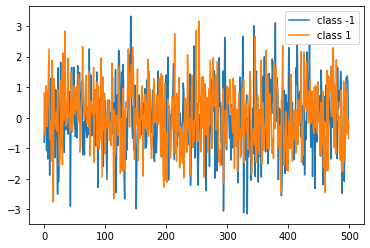

In [33]:
plt.figure()
for c in classes:
    c_x_train = x_train[y_train == c]
    plt.plot(c_x_train[:500], label="class " + str(c))
plt.legend(loc="best")
plt.show()
# plt.close()

<br>

# Standardize the data


Our timeseries are already in a single length (500). However, their values are usually in various ranges. This is not ideal for a neural network; in general we should seek to make the input values normalized. For this specific dataset, the data is already z-normalized: each timeseries sample has a mean equal to zero and a standard deviation equal to one. This type of normalization is very common for timeseries classification problems, see <a href="https://link.springer.com/article/10.1007/s10618-016-0483-9" style="text-decoration:none">Bagnall et al. (2016)</a>.

Note that the timeseries data used here are univariate, meaning we only have one channel per timeseries example. We will therefore transform the timeseries into a multivariate one with one channel using a simple reshaping via numpy. This will allow us to construct a model that is easily applicable to multivariate time series.

In [35]:
# x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
# x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

x_train = x_train.reshape((x_train.shape[0], 1, 1))
x_test = x_test.reshape((x_test.shape[0], 1, 1))

In [37]:
print(x_train.shape)
print(x_test.shape)

(3601, 1, 1)
(1320, 1, 1)


Finally, in order to use <font color=magenta>sparse_categorical_crossentropy</font>, we will have to count the number of classes beforehand.

In [38]:
num_classes = len(np.unique(y_train))
num_classes

2

Now we shuffle the training set because we will be using the <font color=magenta>validation_split</font> option later when training.

In [39]:
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

Standardize the labels to positive integers. The expected labels will then be 0 and 1.

In [40]:
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

<br>

# Build a model

We build a Fully Convolutional Neural Network originally proposed in <a href="https://arxiv.org/abs/1611.06455" style="text-decoration:none">this paper</a>. The implementation is based on the TF 2 version provided <a href="https://github.com/hfawaz/dl-4-tsc/" style="text-decoration:none">here</a>. The following hyperparameters (kernel_size, filters, the usage of BatchNorm) were found via random search using <a href="https://github.com/keras-team/keras-tuner" style="text-decoration:none">KerasTuner</a>.

In [45]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)
    
    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)
    
    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)
    
    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)
    
    gap = keras.layers.GlobalAveragePooling1D()(conv3)
    
    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)
    
    return keras.models.Model(inputs=input_layer, outputs=output_layer)

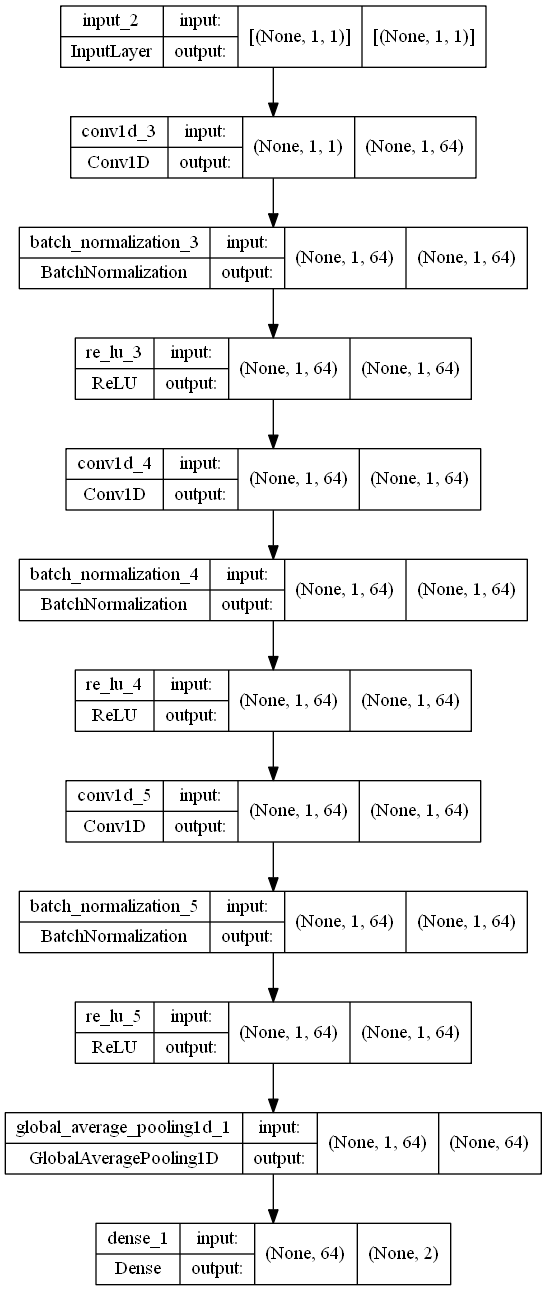

In [46]:
model = make_model(input_shape=x_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

<br>

# Train the model

In [55]:
epochs = 1000
batch_size = 32

callbacks = [keras.callbacks.ModelCheckpoint("best_model.h5",
                                             save_best_only=True,
                                             monitor="val_loss"),
             keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                               factor=0.5,
                                               patience=20,
                                               min_lr=0.0001),
             keras.callbacks.EarlyStopping(monitor="val_loss",
                                           patience=100,
                                           verbose=1)
            ]

model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["sparse_categorical_accuracy"])

history = model.fit(x_train, 
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_split=0.1,
                    verbose=1)

Epoch 1/1000
102/102 [==============================] - 2s 13ms/step - loss: 0.6941 - sparse_categorical_accuracy: 0.5068 - val_loss: 0.6927 - val_sparse_categorical_accuracy: 0.5208 - lr: 0.0010
Epoch 2/1000
102/102 [==============================] - 1s 9ms/step - loss: 0.6932 - sparse_categorical_accuracy: 0.5096 - val_loss: 0.6912 - val_sparse_categorical_accuracy: 0.5512 - lr: 0.0010
Epoch 3/1000
102/102 [==============================] - 1s 9ms/step - loss: 0.6923 - sparse_categorical_accuracy: 0.5386 - val_loss: 0.6911 - val_sparse_categorical_accuracy: 0.5235 - lr: 0.0010
Epoch 4/1000
102/102 [==============================] - 1s 9ms/step - loss: 0.6927 - sparse_categorical_accuracy: 0.5225 - val_loss: 0.6953 - val_sparse_categorical_accuracy: 0.5097 - lr: 0.0010
Epoch 5/1000
102/102 [==============================] - 1s 9ms/step - loss: 0.6943 - sparse_categorical_accuracy: 0.5077 - val_loss: 0.6926 - val_sparse_categorical_accuracy: 0.5319 - lr: 0.0010
Epoch 6/1000
102/102 [==

Epoch 43/1000
102/102 [==============================] - 1s 8ms/step - loss: 0.6915 - sparse_categorical_accuracy: 0.5241 - val_loss: 0.6916 - val_sparse_categorical_accuracy: 0.5512 - lr: 5.0000e-04
Epoch 44/1000
102/102 [==============================] - 1s 8ms/step - loss: 0.6921 - sparse_categorical_accuracy: 0.5210 - val_loss: 0.6926 - val_sparse_categorical_accuracy: 0.5374 - lr: 5.0000e-04
Epoch 45/1000
102/102 [==============================] - 1s 9ms/step - loss: 0.6936 - sparse_categorical_accuracy: 0.5160 - val_loss: 0.6919 - val_sparse_categorical_accuracy: 0.5457 - lr: 5.0000e-04
Epoch 46/1000
102/102 [==============================] - 1s 9ms/step - loss: 0.6925 - sparse_categorical_accuracy: 0.5210 - val_loss: 0.6933 - val_sparse_categorical_accuracy: 0.5485 - lr: 5.0000e-04
Epoch 47/1000
102/102 [==============================] - 1s 9ms/step - loss: 0.6938 - sparse_categorical_accuracy: 0.5136 - val_loss: 0.6927 - val_sparse_categorical_accuracy: 0.5485 - lr: 5.0000e-04


Epoch 84/1000
102/102 [==============================] - 1s 8ms/step - loss: 0.6921 - sparse_categorical_accuracy: 0.5235 - val_loss: 0.6928 - val_sparse_categorical_accuracy: 0.5457 - lr: 1.2500e-04
Epoch 85/1000
102/102 [==============================] - 1s 9ms/step - loss: 0.6912 - sparse_categorical_accuracy: 0.5262 - val_loss: 0.6933 - val_sparse_categorical_accuracy: 0.5291 - lr: 1.2500e-04
Epoch 86/1000
102/102 [==============================] - 1s 9ms/step - loss: 0.6918 - sparse_categorical_accuracy: 0.5256 - val_loss: 0.6928 - val_sparse_categorical_accuracy: 0.5263 - lr: 1.2500e-04
Epoch 87/1000
102/102 [==============================] - 1s 9ms/step - loss: 0.6923 - sparse_categorical_accuracy: 0.5123 - val_loss: 0.6929 - val_sparse_categorical_accuracy: 0.5402 - lr: 1.2500e-04
Epoch 88/1000
102/102 [==============================] - 1s 9ms/step - loss: 0.6925 - sparse_categorical_accuracy: 0.5265 - val_loss: 0.6928 - val_sparse_categorical_accuracy: 0.5402 - lr: 1.2500e-04


<br>

# Evaluate model on test data

In [53]:
model = keras.models.load_model("best_model.h5")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

42/42 [==============================] - 0s 5ms/step - loss: 0.6964 - sparse_categorical_accuracy: 0.5015
Test accuracy 0.5015151500701904
Test loss 0.6963809132575989


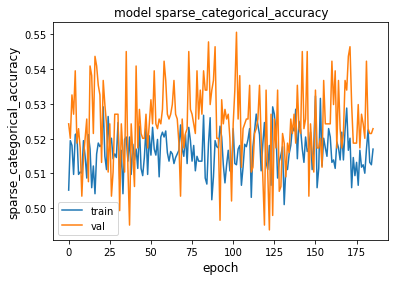

In [54]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()